[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)

#### based on Fig. S2 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from contextlib import contextmanager

import numba

from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol_code import AerosolBoreal, AerosolMarine, AerosolNascent
from PySDM_examples.Lowe_et_al_2019.constants_def import LOWE_CONSTS
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.initialisation.spectra import Sum
from PySDM.physics import si, in_unit

import numpy as np
from joblib import Parallel, delayed, parallel_backend

from matplotlib import pyplot

In [3]:
@contextmanager
def numba_threading_disabled():
    numba_original_num_threads = numba.get_num_threads()
    numba.set_num_threads(1)
    try:
        yield
    finally:
        numba.set_num_threads(numba_original_num_threads)

In [4]:
CI = 'CI' in os.environ
nRes = 10
updraft_list = np.linspace(0.2, 2.4, 2 if CI else nRes)
models = ('Constant', 'CompressedFilmOvadnevaite')

FORMULAE = Formulae(
    constants=LOWE_CONSTS,
)
WATER_MOLAR_VOLUME = FORMULAE.constants.Mv / FORMULAE.constants.rho_w
aerosols = (
    AerosolMarine(water_molar_volume=WATER_MOLAR_VOLUME), 
    AerosolBoreal(water_molar_volume=WATER_MOLAR_VOLUME), 
    AerosolNascent(water_molar_volume=WATER_MOLAR_VOLUME)
)

In [5]:
def compute(keyname, settings):
    simulation = Simulation(settings)
    out = simulation.run()
    out['updraft'] = settings.w
    out['org_fraction'] = settings.aerosol.modes[0]['f_org']
    out['color'] = settings.aerosol.color
    out['Na_tot'] = Sum(
            tuple(settings.aerosol.modes[i]['spectrum']
                  for i in range(len(settings.aerosol.modes)))).norm_factor
    return keyname, out

print(f'tasks scheduled: {len(models) * len(aerosols) * len(updraft_list)}')
print('updrafts:', updraft_list)

with numba_threading_disabled():
    with parallel_backend(backend='threading', n_jobs=-2):
        output = dict(Parallel(verbose=0)(
            delayed(compute)(f"w{w:.2f}_{aerosol.__class__.__name__}_{model}", Settings(
                dz = 10 * si.m if CI else 1 * si.m,
                n_sd_per_mode = 10 if CI else 100,
                model = model,
                aerosol = aerosol,
                w = w * si.m / si.s,
            ))
            for w in updraft_list
            for model in models
            for aerosol in aerosols
        ))

tasks scheduled: 60
updrafts: [0.2        0.44444444 0.68888889 0.93333333 1.17777778 1.42222222
 1.66666667 1.91111111 2.15555556 2.4       ]


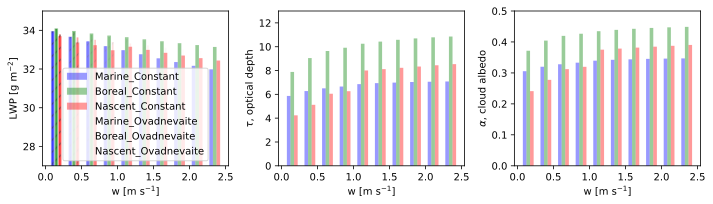

In [6]:
fig, axes = pyplot.subplots(1, 3, figsize=(10,3))

for key, out_item in output.items():
    ll = "_".join(key.split("_", maxsplit=1)[1:]).replace("Aerosol","").replace("CompressedFilm","")
    cc, disp = {
        "Marine": ("b", -0.1),
        "Boreal": ("g", -0.05),
        "Nascent": ("r", 0.0),
    }[ll.split("_", maxsplit=1)[0]]
    w, a, h = {
        "Constant": (0.05, 0.4, ""),
        "Ovadnevaite": (0.025, 0.6, "//"),
    }[ll.split("_", maxsplit=1)[1]]

    ax = axes[0]
    label = ll if key.split("_", maxsplit=1)[0] == "w0.20" else ''
    common_kwargs = {
        'color': cc,
        'width': w,
        'alpha': a,
        'hatch': h
    }

    ax.bar(
        out_item["updraft"] + disp,
        in_unit(out_item["lwp"], si.g / si.m**2),
        **common_kwargs, label=label
    )
    if label != '':
        ax.legend(loc = 0) #bbox_to_anchor=(5, 1))

    ax.set_xlabel("w [m s$^{-1}$]")
    ax.set_ylabel("LWP [g m$^{-2}$]")
    ax.set_ylim(27,35) # 27,33

    ax = axes[1]
    ax.bar(out_item["updraft"] + disp, out_item["tau"], **common_kwargs)
    ax.set_xlabel("w [m s$^{-1}$]")
    ax.set_ylabel("$\\tau$, optical depth")
    ax.set_ylim(0,13) # 0,11

    ax = axes[2]
    ax.bar(out_item["updraft"] + disp, out_item["albedo"], **common_kwargs)
    ax.set_xlabel("w [m s$^{-1}$]")
    ax.set_ylabel("$\\alpha$, cloud albedo")
    ax.set_ylim(0,0.5) # 0,0.45

pyplot.tight_layout()
show_plot()